# Spatial Interpolation

Converting information from a geopandas file with one set of boundaries (census tracts) to another set of boundaries (zip codes)

This example is working from example data files from pysal,  loaded by the libpysal load_example function

The documentation on libpysal files is limited, but there are some tools to let us see what the example data is and where it is
located

It looks like the libpysal files are giving us the data in a wide variety of data formats including GIS shape files, geojson
files,  sqlite files and a number of others I don't recognize.   

This example is a bit complex to deal with,  but it carries out a task that is quite helpful,  interpolating data from census
tracts to other types of spatial groupings,  such as neighborhoods,   police or fire districts, or sales districts, or regions
around stores or company sites

There are also some interesting code moves in here that could be useful

https://pysal.org/tobler/notebooks/01_interpolation_methods_overview.html

In [2]:
!pip install tobler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.7 MB/s eta 0:00:00


In [5]:
!pip install watermark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tobler.dasymetric import masked_area_interpolate
from tobler.model import glm
from tobler.area_weighted import area_interpolate
from libpysal.examples import load_example
import pandas as pd

In [6]:
%load_ext watermark
%watermark
%watermark -iv

Last updated: 2024-03-12T22:09:26.542110+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.7.1
geopandas : 0.13.2
pandas    : 1.5.3



In [7]:
# this command will download a lot of spatial data examples,  best to do it on a school computer withe deep freeze if you can
# I can't figure out how to download just one file or one set of files

c1 = load_example('Seattle1')
c2 = load_example('Seattle2')

The command below will show us what data sets are available

In [8]:
from libpysal.examples import available
temp=(available())
temp

,Name,Description,Installed
0,10740,"Albuquerque, New Mexico, Census 2000 Tract Dat...",True
1,AirBnB,"Airbnb rentals, socioeconomics, and crime in C...",False
2,Atlanta,"Atlanta, GA region homicide counts and rates",False
3,Baltimore,Baltimore house sales prices and hedonics,False
4,Bostonhsg,Boston housing and neighborhood data,False
...,...,...,...
93,taz,Traffic Analysis Zones in So. California,False
94,tokyo,Tokyo Mortality data,True
95,us_income,Per-capita income for the lower 48 US states 1...,True
96,virginia,Virginia counties shapefile,True


I find the way Jupyter notebooks handles the display of larger datasets a bit frustrating,  it is hard to see as much as I'd
like to.

I found the HTML command, that will show us an entire data frame in a scrolling window

In [9]:
from IPython.display import HTML

HTML(temp.to_html())

,Name,Description,Installed
0,10740,"Albuquerque, New Mexico, Census 2000 Tract Data. 10740 is the Core Based Statistical Area (CBSA) code for Albuquerque, New Mexico.",True
1,AirBnB,"Airbnb rentals, socioeconomics, and crime in Chicago",False
2,Atlanta,"Atlanta, GA region homicide counts and rates",False
3,Baltimore,Baltimore house sales prices and hedonics,False
4,Bostonhsg,Boston housing and neighborhood data,False
5,Buenosaires,Electoral Data for 1999 Argentinean Elections,False
6,Charleston1,"2000 Census Tract Data for Charleston, SC MSA and counties",False
7,Charleston2,"1998 and 2001 Zip Code Business Patterns (Census Bureau) for Charleston, SC MSA",False
8,Chicago Health,Chicago Health + Socio-Economics,False
9,Chicago commpop,Chicago Community Area Population Percent Change for 2000 and 2010,False


We loaded two data sets about Seattle,  Seattle 1 and Seattle 2, which are Census tract data and zip code data for Seattle.

We would like to transfer information from the Census tract onto zip code.

We know the zip codes of our customers, for example, and we might want to carry out a marketing campaign via zip code,  so
there are many reasons to want to have data related to zip code

Census data and zip code information are both public data, so they are useful in many settings

In [10]:
# c1 was the Seattle census tract data

# libpysal has supplied it in many, many ways, including in ARC GIS shapefiles,  which is what this example code uses
#  I would probably trying just loading the geojson file,  that seems pretty straightforward

c1.get_file_list()

['/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_final_census2.sbx',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_final_census2.sbn',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_msa_counties.sbx',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._2000 Census Data Variables_Documentation.pdf',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_msa_counties.shx',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_msa_counties.shp',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_msa_counties.sbn',
 '/root/.local/share/pysal/Seattle1/__MACOSX/SeattleMSA/._wa_msa_counties.dbf',
 '/root/.local/share/pysal/Seattle1/__MACOSX/._SeattleMSA',
 '/root/.local/share/pysal/Seattle1/SeattleMSA/wa_final_census2..xlsx',
 '/root/.local/share/pysal/Seattle1/SeattleMSA/wa_msa_counties.mif',
 '/root/.local/share/pysal/Seattle1/SeattleMSA/wa_msa_counties.kml',
 '/root/.local/share/pysal/Seattle1/SeattleMSA/wa_final_census2

Set the CRS for the loading process

In [11]:
# the original example was in South Carolina,  in Charlotte

# the data is often stored in lat and long, which are angular positions on the surface of the globe,  to do calculations
# of distances or areas, such as we are using here, we need a projection of the angular locations onto cartesion coordinates
# on the tangent plane to the globe at the desired location.  We want to express these distances in feet or meters to
# some specific reference point, the center point of the tanget plane

# The distances in the tangent plane have slight errors in them, as the earth is not flat, and we are attempting to use
# flat euclidean geometry, instead of great circle distances.   Errors accumulate with increased distance from the reference
# point used for the tangent plain.

# I looked up crs 6569, it is a coordinate reference system in feet used in South Carolina
#  https://epsg.io/6569

# due to data availabity, we are using data from Seattle,  so we need a CRS in feet for Washington
# EPSG 2285, northern Washington in feet

# Google search was
# site was https://www.spatialreference.org/ref/?search=Washington
# this site listed all the different CRS codes and types by US state- handy!

crs = 2285  # https://epsg.io/6569

load the census tract data, converting it to our desired crs for Washington

In [12]:
tracts = gpd.read_file(c1.get_path('wa_final_census2.shp')).to_crs(crs)

In [13]:
type(tracts)

geopandas.geodataframe.GeoDataFrame

In [14]:
tracts.head()

,FIPS,MSA,TOT_POP,POP_16,POP_65,WHITE,BLACK,ASIAN,HISP,MULTI_RA,...,EMP_FEM,OCC_MAN,OCC_OFF1,OCC_INFO,HH_INC,POV_POP,POV_TOT,HSG_VAL,POLYID,geometry
0,53061053700,Seattle,2821,663,421,2652,0,3,22,54,...,578,188,79,6,35052,2815,318,128000,0,"POLYGON ((1568234.903 361236.306, 1568185.790 ..."
1,53061053400,Seattle,4757,1086,388,4393,5,51,34,75,...,1039,360,416,47,59375,4757,162,212100,1,"POLYGON ((1324732.163 441715.460, 1324705.867 ..."
2,53061053506,Seattle,4987,1278,412,4778,19,6,126,22,...,1103,318,500,51,56000,4894,532,179900,2,"POLYGON ((1391591.309 416211.789, 1391354.859 ..."
3,53061053302,Seattle,4753,1211,427,4450,33,69,19,11,...,978,264,360,13,59018,4679,302,193000,3,"POLYGON ((1295164.692 476472.359, 1295274.777 ..."
4,53061053301,Seattle,4542,1424,658,3963,29,58,244,197,...,848,119,355,0,46332,4527,494,161800,4,"POLYGON ((1257835.968 459439.446, 1257681.256 ..."


Now we need to get the zip code data, so we'll check the file list for c2

In [15]:
temp2=pd.DataFrame(c2.get_file_list())
HTML(temp2.to_html())

,0
0,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000009.gdbtablx
1,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000007.CatRelTypesByOriginItemTypeID.atx
2,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000004.CatItemsByType.atx
3,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000006.CatRelsByType.atx
4,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000006.CatRelsByOriginID.atx
5,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000001.gdbtablx
6,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000005.CatItemTypesByName.atx
7,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/timestamps
8,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000001.gdbindexes
9,/root/.local/share/pysal/Seattle2/SeattleMSA2/SeattleMSA2.gdb/a00000006.FDO_UUID.atx


In [16]:
zip_codes = gpd.read_file(c2.get_path('SeattleMSA2.shp')).to_crs(crs)

In [17]:
type(zip_codes)

geopandas.geodataframe.GeoDataFrame

In [18]:
zip_codes.head()

,ZIP,PO_NAME,STATE,POP2001,MSA,EST98,EMP98,PAY98,EST01,EMP01,...,INFOUS01_1,INFOUS01_3,INDEX,NUMSEC,PCTNGE,PCTIME,PCTCSE,PCTGRO,ID,geometry
0,98241,DARRINGTON,WA,1940,Seattle,40,468,13299,41,455,...,89935,47358,659,13,2.21,-1.25,-7.78,-6.82,0,"POLYGON ((1622631.136 424546.639, 1609121.347 ..."
1,98223,ARLINGTON,WA,36244,Seattle,810,9353,259006,837,8722,...,89935,47358,657,21,2.21,-0.37,0.35,2.20,1,"POLYGON ((1327991.493 393623.059, 1327994.019 ..."
2,98292,STANWOOD,WA,17897,Seattle,621,3871,84210,483,3473,...,89935,47358,669,19,2.21,-0.06,8.32,10.47,2,"POLYGON ((1290749.929 418828.913, 1290504.060 ..."
3,98252,GRANITE FALLS,WA,7023,Seattle,108,533,11931,120,673,...,89935,47358,661,19,2.21,-0.29,3.34,5.26,3,"POLYGON ((1488968.270 353922.824, 1488955.949 ..."
4,98271,MARYSVILLE,WA,23362,Seattle,253,3591,106708,311,4431,...,89935,47358,664,19,2.21,-1.10,13.65,14.76,4,"POLYGON ((1310067.552 381087.064, 1310052.771 ..."


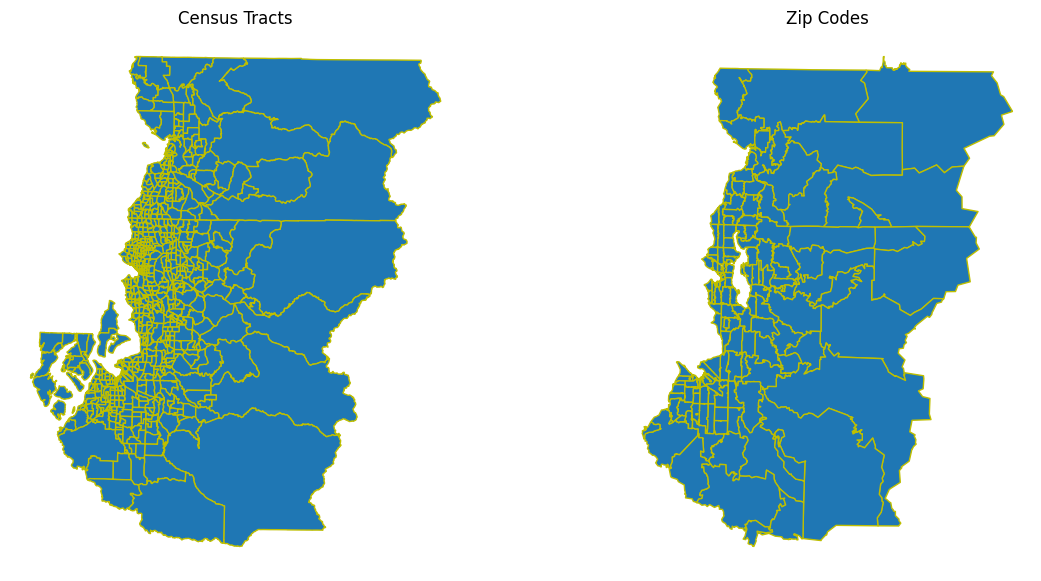

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

tracts.plot(ax=ax[0],edgecolor="y")
zip_codes.plot(ax=ax[1],edgecolor="y")

ax[0].set_title('Census Tracts')
ax[1].set_title("Zip Codes")

for ax in ax:
    ax.axis('off')

In [20]:
tracts.columns

Index(['FIPS', 'MSA', 'TOT_POP', 'POP_16', 'POP_65', 'WHITE', 'BLACK', 'ASIAN',
       'HISP', 'MULTI_RA', 'MALES', 'FEMALES', 'MALE1664', 'FEM1664', 'EMPL16',
       'EMP_AWAY', 'EMP_HOME', 'EMP_29', 'EMP_30', 'EMP16_2', 'EMP_MALE',
       'EMP_FEM', 'OCC_MAN', 'OCC_OFF1', 'OCC_INFO', 'HH_INC', 'POV_POP',
       'POV_TOT', 'HSG_VAL', 'POLYID', 'geometry'],
      dtype='object')

In [21]:
# this is what the example used as percent poverty.  Hmm

tracts['pct_poverty'] = tracts.POV_POP/tracts.POV_TOT

# The libpysal example did come with a pdf data dictionary for the census data
# here are the definitions

# pov_pop* P087001 Population for whom poverty status is determined: Total Population
# pov_tot* P087002 Population for whom poverty status is determined: Income in 1999 below poverty level


## Areal Interpolation

The basic approach used to interpolate data from the census data into the zip code data is an "areal" interpolation based on
the percentages of share area

Ie zip code 21120 might be made up of 40% Census block 11, 50% of block 3 and 10% of block 19,  so we could use that
mixture information to estimate the values of each variable desired into zipcode 21120

Note that variables have two different types of relationship to the area of a census zone or zip code

Extensive variables depend on the extent of the area,   so number of people would be extensive, number of houses is extensive

Intensive variables do not depend on the extent of the area,  so average rainfall,   population density, percent poverty are
all intensive variables

If you think about it, the process of interpolation depends on whether variables are extensive or intensive, so we have to
specify that.


{note that the concepts of intensive and extensive are critical in thermodynamics,   which was a bit part of my "past life"
So is entropy or information for that matter}

In [22]:
results = area_interpolate(source_df=tracts, target_df=zip_codes, intensive_variables=['pct_poverty'], extensive_variables=['EMP_MALE'])

/usr/local/lib/python3.10/dist-packages/tobler/util/util.py:53: UserWarning: nan values in variable: pct_poverty, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")
/usr/local/lib/python3.10/dist-packages/tobler/util/util.py:66: UserWarning: inf values in variable: pct_poverty, replacing with 0
  warn(f"inf values in variable: {column}, replacing with 0")


In [23]:
# note in the plots that legends_kwds passes legend control parameters to matplotlib, so I could relocate the legend

In [25]:
!pip install mapclassify

Text(0.5, 0.98, 'Male Employment (extensive)')

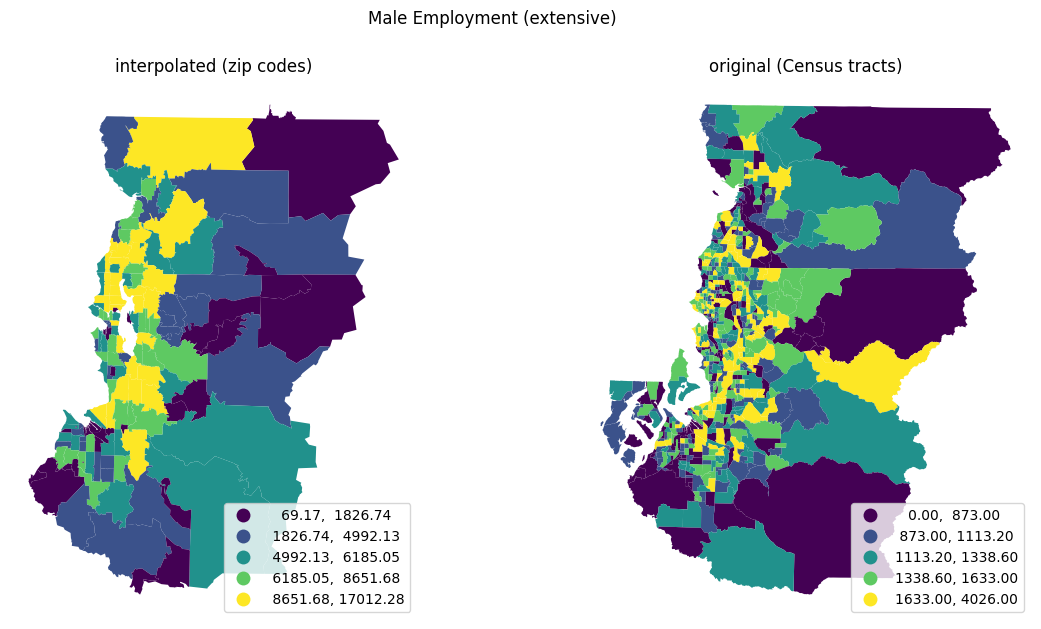

In [26]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('EMP_MALE', scheme='quantiles',  ax=ax[0],legend=True,legend_kwds={'loc':"lower right"})
tracts.plot('EMP_MALE', scheme='quantiles',  ax=ax[1],legend=True,legend_kwds={'loc':"lower right"})

ax[0].set_title('interpolated (zip codes)')
ax[1].set_title('original (Census tracts)')
for ax in ax:
    ax.axis('off')
fig.suptitle('Male Employment (extensive)')

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:939: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:969: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 if adam == 0 else 1 - self.adcm / adam


Text(0.5, 0.98, 'Poverty Rate (intensive)')

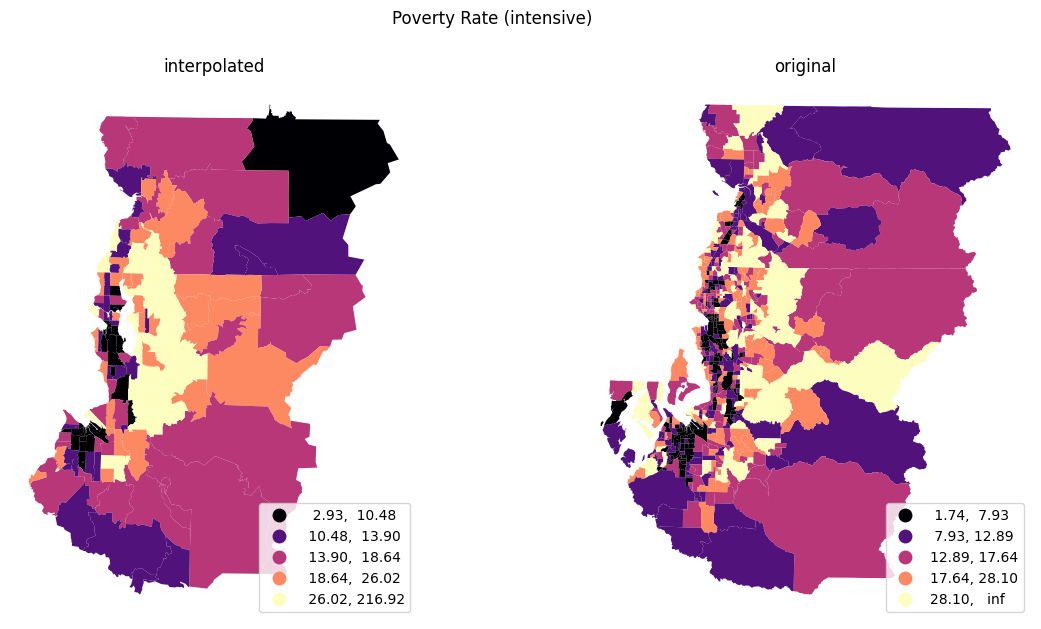

In [27]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[0],legend=True,legend_kwds={'loc':"lower right"})
tracts.plot('pct_poverty', scheme='quantiles', cmap='magma',  ax=ax[1],legend=True,legend_kwds={'loc':"lower right"})

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')
fig.suptitle('Poverty Rate (intensive)')

## Dasymetric Interpolation

To improve the estimation, we probably want to exclude areas that are not developed

We can get get raster images of land cover from a us national land cover database

The raster data can be converted to geographic information and used to mask out the unpopulated regions of the geographic range, greatly improving the interpolation

However, it requires a lot of packages to work with raster (pixel) data from images in the GIS framework

# Question/Action

Complete the other notebooks for this week before starting in on these homework problems.

It will be easiest to do problem 1 in this notebook (Spatial_interpolation.ipynb), and to create a different notebook for the other 3 problems.

1.) In this data set,  create a copy of tracts (tracts2) and set the crs of the copy to epsg 6569  (crs=6569), and then plot pct_povery from tracts and tracts2,
side by side.   What happens when you use the wrong projection?

2.) Get the Buffalo Census data ACS_2017 and the 2010 Census tract maps.   Use the join tactic seen in Notebook
"pysal_spatial_autocorrelation" to join the geometry data in the 2010 census tract maps to the other data in ACS_2017

3.) Use the tactics from this notebook to interpolate several variables (your choice) from the Census data set with the geometry
from step one and map this onto the neighborhood maps from open data buffalo

4.) Analysize poverty levels in Buffalo, using your data set from step 1 and the methods of Spatial Autocorrelation from the
"pysal_spatial_autocorrelation" notebook

1.) In this data set, create a copy of tracts (tracts2) and set the crs of the copy to epsg 6569 (crs=6569), and then plot pct_povery from tracts and tracts2, side by side. What happens when you use the wrong projection?

In [29]:
tracts2 = tracts.copy()
tracts2.crs = 6569

Text(0.5, 0.98, 'Male Employment (extensive)')

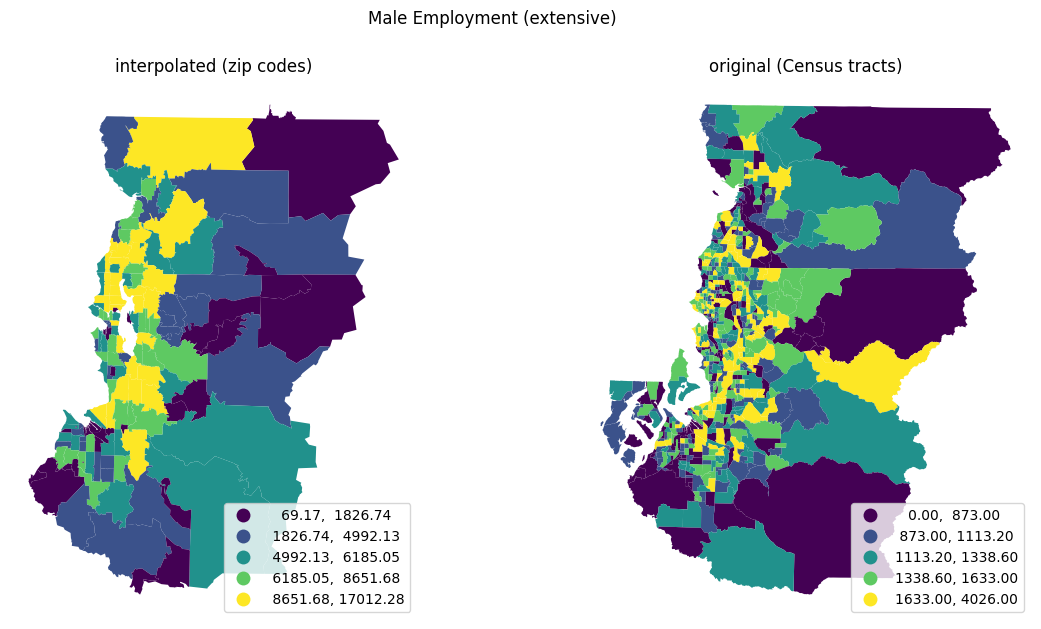

In [30]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

results.plot('EMP_MALE', scheme='quantiles',  ax=ax[0],legend=True,legend_kwds={'loc':"lower right"})
tracts2.plot('EMP_MALE', scheme='quantiles',  ax=ax[1],legend=True,legend_kwds={'loc':"lower right"})

ax[0].set_title('interpolated (zip codes)')
ax[1].set_title('original (Census tracts)')
for ax in ax:
    ax.axis('off')
fig.suptitle('Male Employment (extensive)')